# Covariate Analysis 

In this notebook we'll use the merged table we constructed to analyze the impact of covariates on healthy individuals. We'll first  collect the table, then use regression to calculate assocations between geographic location, age and sex with abundance. 
_______

In [1]:
from utils import *
import pandas as pd
import scipy.stats
import seaborn as sns
import numpy as np
import statsmodels
import matplotlib.pyplot as plt

%matplotlib inline

## Filter Dataframes
First we'll build a dataframe of all reads in the meta-analysis pertaining to healthy samples, as well as those with associated metadata. Since reads have been removed from the original dataframe, we'll redo CLR calculations

In [2]:
# load table
merged_table = pd.read_csv('../data/merged_table.csv', index_col = 0)

# filter to just controls
res = merged_table[merged_table.condition == 'control']
res = clr(filter_taxa(res, min_reads=10, min_prevalence=0.05)) 

# filter to just controls with sex metadata
res_sex = res[~pd.isnull(res.sex)] 
res_sex = clr(filter_taxa(res_sex, min_reads=10, min_prevalence=0.05)) 

# filter to just controls with age metadata
res_age = res[~pd.isnull(res.age)] 
res_age = clr(filter_taxa(res_age, min_reads=10, min_prevalence=0.05))

## Geographic location
For location, we'll run an linear regression correcting for 16S sequencing hypervariable region, sequencing method and URT collection site to look for taxa significantly enriched across locations

In [3]:
# initialize dataframes
results = pd.DataFrame({'genus':[]})
pframe_loc = pd.DataFrame()

# iterate through genera 
for genus in res['genus'].unique():
    res_temp = res[res['genus']==genus]
    
    # linear regression
    mod = statsmodels.formula.api.ols(formula = 'clr ~ region + hypervariable_region + sequencing + URT',
                                      data = res_temp) 
    reg = mod.fit() #fit to regression
    
    #create dataframe of pvalues
    pframe_loc = pd.concat([pframe_loc, 
                        reg.pvalues[reg.pvalues.index.str.startswith('region')]], axis = 1).rename(columns = {0:genus})
    pframe_loc.dropna(axis = 1, how = 'all', inplace = True)
    
# add significantly enriched genera to results
for genus in pframe_loc.columns:
    corrected_pvalue = statsmodels.stats.multitest.fdrcorrection(pframe_loc[genus].dropna())[1]
    if corrected_pvalue.min()<0.05:
            results = pd.concat([results, pd.DataFrame({'genus':[genus]})])
            
# create dataframe for plots
for_plots_loc = res[res['genus'].isin(results['genus'])].groupby(
    ["kingdom", "phylum", "class", "order", "family","genus","study"]).mean().reset_index()
for_plots_loc = pd.pivot_table(for_plots_loc, index = 'genus', columns = 'study', values = 'clr').fillna(0.0)

## Visualize Results
Create a heatmap to visualize the results

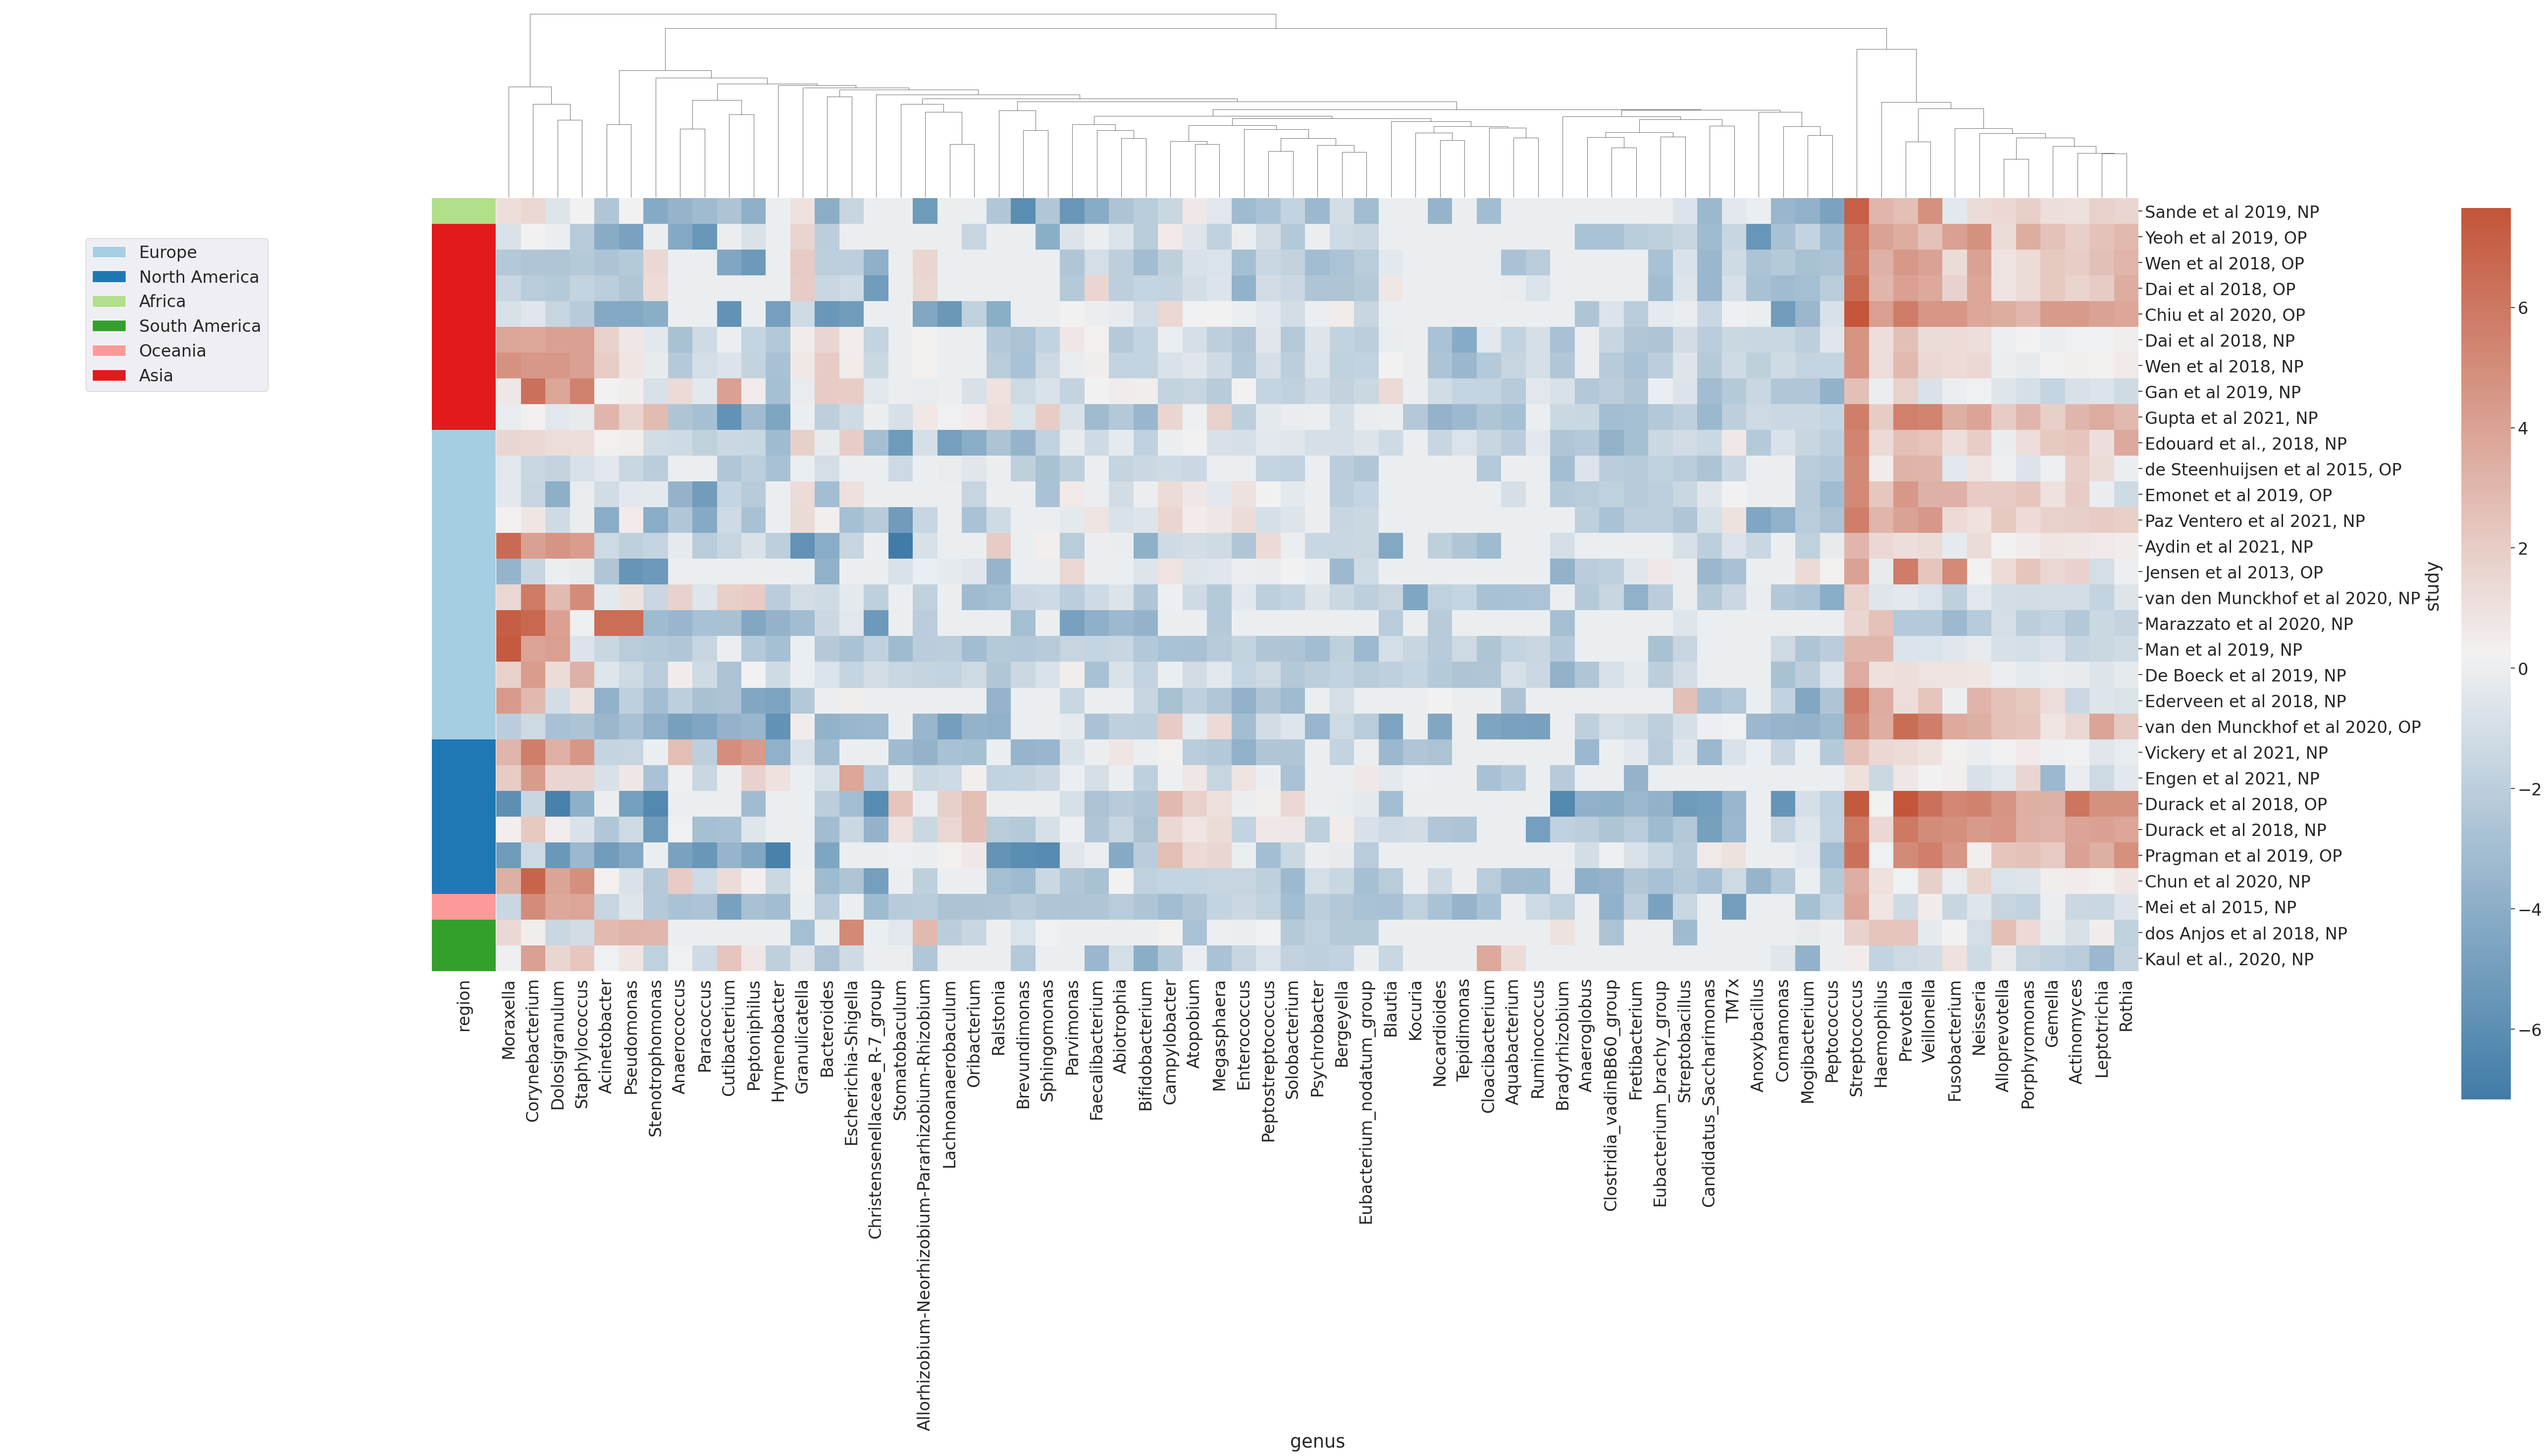

In [10]:
region_list = res.drop_duplicates(subset = 'study').set_index('study')['region']
palette = sns.color_palette("Paired", 10)
lut = dict(zip(region_list.unique(),palette))
row_colors = region_list.map(lut)

for_plots_loc = for_plots_loc[region_list.sort_values().index]

sns.set(font_scale=2.2)

ax_loc = sns.clustermap(for_plots_loc.T,
                    cmap=sns.diverging_palette(240,20,center='light',as_cmap=True),
                    figsize = (50,30),
                    row_cluster = False,
                    xticklabels = True,
                    row_colors = row_colors,
                    cbar_pos=[1,.25,.02,.6])
for label in res['region'].unique():
    ax_loc.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=1)
ax_loc.ax_col_dendrogram.legend(loc=[-.25,-1], ncol=1)
ax_loc.savefig('../visualizations/covariates_location.svg', dpi=300, bbox_inches="tight", format = 'svg')

## Age 

For age, we will use regression analysis to find associations, correcting for URT sampling site and geographic region

In [5]:
# defined squared term to search for non-linear relationships
res_age['age2'] = np.square(res_age['age'])

# initialize dataframe
pframe_age = pd.DataFrame()

# iterature through genera
for genus in res_age['genus'].unique():
    res_temp = res_age[res_age['genus']==genus]
    
    # linear regression
    mod = statsmodels.formula.api.ols(formula = 'clr ~ age + age2 + region + hypervariable_region + sequencing + URT',
                                      data = res_temp) 
    reg = mod.fit() 
    pframe_age = pd.concat([pframe_age, reg.pvalues[reg.pvalues.index.str.startswith('age')]], axis = 1).rename(columns = {0:genus})

    
# fdr correction of pvalues and filtering
pframe_age = pframe_age.T.sort_values(by = 'age')
pframe_age['age'] = statsmodels.stats.multitest.fdrcorrection(pframe_age['age'], method = 'indep')[1]
pframe_age['age2'] = statsmodels.stats.multitest.fdrcorrection(pframe_age['age'], method = 'indep')[1]
pframe_age = pframe_age[(pframe_age['age']<0.05)|(pframe_age['age2']<0.05)]

# format results for plotting
for_plots_age = res_age.groupby(
    ["kingdom", "phylum", "class", "order", "family","genus","age"]).mean().reset_index()
for_plots_age = for_plots_age[for_plots_age['genus'].isin(pframe_age[(pframe_age['age']<0.05)|(pframe_age['age2']<0.05)].index)]
for_plots_age['quad'] = pd.cut(for_plots_age['age'], [0,1,4,9,35,97], labels = ['0-1','1-4','4-9','9-35','35-97'])
for_plots_age = pd.pivot_table(for_plots_age, index = 'genus', columns = 'quad', values = 'clr').fillna(0.0)
for_plots_age

quad,0-1,1-4,4-9,9-35,35-97
genus,,,,,
Absconditabacteriales_(SR1),-2.983167,-2.265265,-2.438668,0.744397,-1.181650
Actinomyces,-0.812622,1.110560,1.886824,1.067375,1.991177
Alloprevotella,1.678495,0.726062,0.818183,1.732357,1.914259
Bifidobacterium,-2.281986,-2.015001,-1.454957,-1.825633,-2.294157
Campylobacter,-2.790342,-1.396567,-0.395599,0.059314,1.259568
Corynebacterium,2.689217,2.297901,1.041919,1.986338,2.693091
Dolosigranulum,0.317311,4.351463,0.809509,1.217946,-0.119621
Eubacterium_nodatum_group,-2.097884,-2.245403,-1.288617,-0.619927,-0.920614
Fusobacterium,-0.236377,1.444464,2.723838,3.211338,1.469211


## Visualize Results
Create a heatmap to visualize results

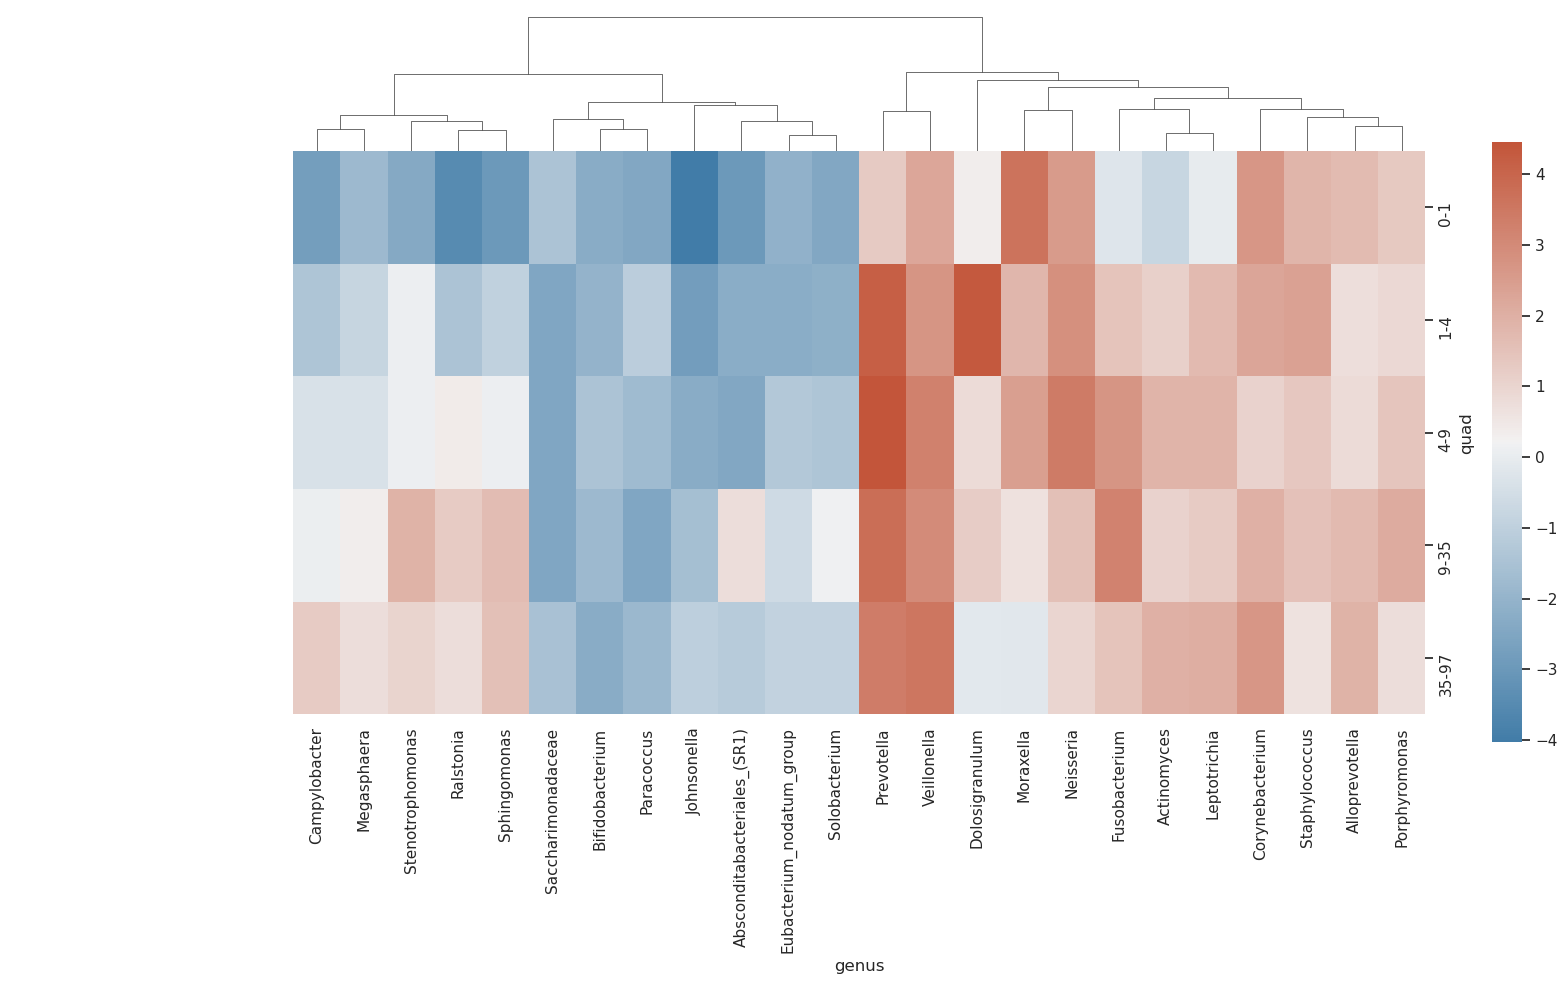

In [6]:
sns.set(font_scale=1)
ax_age = sns.clustermap(for_plots_age.T,
                    cmap=sns.diverging_palette(240,20,center='light',as_cmap=True),
                    figsize = (15,10),
                    yticklabels = True,
                    row_cluster = False,
                    col_cluster = True,
                    cbar_pos=[1,.25,.02,.6])

In [ ]:
ax_age.savefig('../visualizations/covariates_age.svg', dpi=300, bbox_inches="tight", format = 'svg')

## Sex
We will do the same regression analysis with sex as a covariate

In [7]:
pframe_sex = pd.DataFrame()
for genus in res_sex['genus'].unique():
    res_temp = res_sex[res_sex['genus']==genus]
    mod = statsmodels.formula.api.ols(formula = 'clr ~ sex + region + hypervariable_region + sequencing + URT',
                                      data = res_temp) #ordinary least squares
    reg = mod.fit() #fit to regression
    pframe_sex = pd.concat([pframe_sex, reg.pvalues[reg.pvalues.index.str.startswith('sex')]], axis = 1).rename(columns = {0:genus})
for_plots_sex= res_sex.groupby(
    ["kingdom", "phylum", "class", "order", "family","genus","sex"]).mean().reset_index()
pframe_sex = pframe_sex.T.sort_values(by = 'sex[T.M]')
pframe_sex['sex[T.M]'] = statsmodels.stats.multitest.fdrcorrection(pframe_sex['sex[T.M]'], method = 'indep')[1]
for_plots_sex = for_plots_sex[for_plots_sex['genus'].isin(pframe_sex[pframe_sex['sex[T.M]']<0.05].index)]
for_plots_sex = pd.pivot_table(for_plots_sex, index = 'genus', columns = 'sex', values = 'clr').fillna(0.0)
for_plots_sex

sex
genus


No significant results were seen